<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-Do-calculus" data-toc-modified-id="The-Do-calculus-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The Do-calculus</a></span><ul class="toc-item"><li><span><a href="#Rule-1:-Ignoring-observations" data-toc-modified-id="Rule-1:-Ignoring-observations-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Rule 1: Ignoring observations</a></span></li><li><span><a href="#Rule-2:-Action/Observation-Change" data-toc-modified-id="Rule-2:-Action/Observation-Change-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Rule 2: Action/Observation Change</a></span></li><li><span><a href="#Rule-3:-Ignoring-actions" data-toc-modified-id="Rule-3:-Ignoring-actions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Rule 3: Ignoring actions</a></span></li></ul></li><li><span><a href="#Concepts-required-to-understand-ID-algorithm" data-toc-modified-id="Concepts-required-to-understand-ID-algorithm-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Concepts required to understand ID algorithm</a></span><ul class="toc-item"><li><span><a href="#Theorem-2:-The-bow-arc-is-not-identifiable." data-toc-modified-id="Theorem-2:-The-bow-arc-is-not-identifiable.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Theorem 2: The bow arc is not identifiable.</a></span></li><li><span><a href="#Trees-point-toward-the-root!" data-toc-modified-id="Trees-point-toward-the-root!-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Trees point toward the root!</a></span></li><li><span><a href="#$An(-Y-)$-includes-$Y$" data-toc-modified-id="$An(-Y-)$-includes-$Y$-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>$An( Y )$ includes $Y$</a></span></li><li><span><a href="#C-component" data-toc-modified-id="C-component-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>C-component</a></span></li><li><span><a href="#Definition-4:-(C-tree)" data-toc-modified-id="Definition-4:-(C-tree)-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Definition 4: (C-tree)</a></span></li><li><span><a href="#Theorem-3" data-toc-modified-id="Theorem-3-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Theorem 3</a></span></li><li><span><a href="#Definition-5-(C-forest):" data-toc-modified-id="Definition-5-(C-forest):-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Definition 5 (C-forest):</a></span></li><li><span><a href="#Definition-6-(hedge):" data-toc-modified-id="Definition-6-(hedge):-2.8"><span class="toc-item-num">2.8&nbsp;&nbsp;</span>Definition 6 (hedge):</a></span></li><li><span><a href="#Theorem-17" data-toc-modified-id="Theorem-17-2.9"><span class="toc-item-num">2.9&nbsp;&nbsp;</span>Theorem 17</a></span></li></ul></li><li><span><a href="#ID*-algorithm" data-toc-modified-id="ID*-algorithm-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ID* algorithm</a></span></li></ul></div>

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [1]:
import itertools as itt
from typing import Callable, Collection, Iterable, Set, Tuple, Union

from scipy.stats import bernoulli
import matplotlib.pyplot as plt
from IPython.display import Latex, Markdown, set_matplotlib_formats

from y0.examples import complete_hierarchy_figure_3a_example as figure_3a
from y0.examples import figure_9a, figure_9b, figure_9c
from y0.algorithm.identify import Identification, identify
from y0.dsl import P, Sum, D, X, Y, Y1, Y2, W1, W2, Product, Variable
from y0.dsl import _get_treatment_variables, _get_outcome_variables
from y0.algorithm.identify.id_std import (
    line_1,
    line_2,
    line_3,
    line_4,
    line_6,
    line_7,
)
from y0.graph import NxMixedGraph
from y0.dsl import Variable

In [2]:
set_matplotlib_formats("svg")

# The Do-calculus



Representing an interventional probability using 3 different notations:

* **counterfactual notation**: An intervention is represented as a subscript on the outcome variables. Note that this is strictly more expressive, as it can represent probabilistic expressions over multiple worlds, such as $P(y_x | x',y')$
* **do-notation**: an intervention is on the rhs of a conditional, wrapped in a $do()$ function: $P(y|do(x))$ 
* and **interventional distribution notation**: An intervention is represented as a subscript on the Probabilistic expression: $P_x(y)$ 

$$P(y_x) = P(y|do(x)) = P_x(y)$$


## Rule 1: Ignoring observations


$$\newcommand\ci{\perp\!\!\!\perp}$$
$$\newcommand{\ubar}[1]{\underset{\bar{}}{#1}}
\newcommand{\obar}[1]{\overset{\bar{}}{#1}}$$

$$P(y|do(x),{\color{blue}z},w) = P(y|do(x),w)\text{ if } ( Y\ci Z|X,W )_{G_{\bar{X}}}$$

or in the interventional distribution notation:

$$P_x(y|{\color{blue}z},w) = P_x(y|w)\text{ if } ( Y\ci Z|X,W )_{G_{\bar{X}}}$$

## Rule 2: Action/Observation Change

$$P(y|do(x), \color{red}{do(z)}, w) = P(y|do(x),\color{red} z, w)\text{ if } (Y\ci Z|X,W)_{G_{\bar{X},\ubar{Z}}}$$
or in interventional distribution notation:

$$P_{x,\color{red}z}(y|w) = P_x(y|\color{red}z,w) \text{ if } (Y\ci Z|X,W)_{G_{\bar{X},\ubar{Z}}}$$

Where $G_{\bar{X},\ubar{Z}}$  is taken to mean the graph obtained from $G$ by removing arrows pointing to $X$ and arrows leaving $Z$. 

## Rule 3: Ignoring actions

$$P(y|do(x),\color{green}{do(z)},w) = P(y|do(x),w)\text{ if }(Y\ci Z|X,W)_{G_{\bar{X}\bar{Z(W)}}}$$

or in interventional distribution notation:
$$P_{x,\color{green}{z}}(y|w) = P_x(y|w)\text{ if }(Y\ci Z|X,W)_{G_{\bar{X}\bar{Z(W)}}}$$

where $Z(W)$ is the set of $Z$ nodes not ancestors of any $W$-node in $G_{\bar{X}}$.



# Concepts required to understand ID algorithm

## Theorem 2: The bow arc is not identifiable.

We construct two causal models $M^1$ and $M^2$ such that $P^1(X, Y)=P^2(X, Y)$ ,and $P^1_x(Y)\ne P^2_x(Y)$. The two models agree on the following: all 3 variables are boolean, $U$ is a fair coin, and $f_X(u)=u$. Let $⊕$ denote the exclusive or (XOR) function. Then the value of $Y$ is determined by the function $u⊕x$ in $M^1$, while $Y$ is set to $y'$ in $M^2$. Then $P^1(y')=P^2(y')=1$, $P^1( x')=P^2( x')=0.5$. Therefore, $P^1(X, Y)=P^2(X, Y)$, while $P^2(y' |do(x'))=1\ne P^1(y'|do(x'))=0.5$. Note that while $P$ is non-positive, it is straightforward to modify the proof for the positive case by letting $f_Y$ functions in both models return 1 half the time, and the values outlined above half the time.



In [3]:
def M1(u: bool) -> Tuple[bool, bool]:
    """The value of Y is determined by u XOR x"""
    x = u
    y = x ^ u
    return x, y


def M2(u: bool) -> Tuple[bool, bool]:
    """The value of Y is always y'"""
    x = u
    y = False
    return x, y


def M1x(u: bool) -> Tuple[bool, bool]:
    """X is always x' but Y is determined by u XOR x"""
    x = False
    y = x ^ u
    return x, y


def M2x(u: bool) -> Tuple[bool, bool]:
    """X is always x' and Y is always y'"""
    x = False
    y = False
    return x, y


def Prob(
    model: Callable[[bool], Tuple[bool, bool]],
    X: Union[bool, None] = None,
    Y: Union[bool, None] = None,
    p: float = 0.5,
    samples: int = 10000,
) -> float:
    u = bernoulli.rvs(p, size=samples)
    joint = [model(bool(u_i)) for u_i in u]
    count = 0
    for x, y in joint:
        if X is not None and Y is not None and X == x and Y == y:
            count += 1
        elif Y is None and X == x:
            count += 1
        elif X is None and Y == y:
            count += 1

    return count / float(samples)


display(
    Markdown(
        f"""
$$P^1(y') = {Prob(M1, Y=False)} = P^2(y') = {Prob(M2, Y=False)}$$
$$P^1(x') = {Prob(M1, X=False)} \\approx P^2(x') = {Prob(M2, X=False)}$$
$$P^1(y' | do(x')) = {Prob(M1x, Y=False)} \\neq P^2(y'| do(x')) = {Prob(M2x, Y=False)}$$
"""
    )
)


$$P^1(y') = 1.0 = P^2(y') = 1.0$$
$$P^1(x') = 0.504 \approx P^2(x') = 0.5028$$
$$P^1(y' | do(x')) = 0.5066 \neq P^2(y'| do(x')) = 1.0$$


## Trees point toward the root!

In computer science, the root of a tree has no parents, the leaves have no children, and all nodes have at most one parent.

In the Pearlian world, the arrows point in the opposite direction, so the root of a tree has no children, the leaves have no parents, and all nodes have at most one child.   



## $An( Y )$ includes $Y$

From "[A General Identification Condition for Causal Effects](https://ftp.cs.ucla.edu/pub/stat_ser/R290-A.pdf)" by Tian and Pearl 2002:

Let  $An( S )$ denote  the  union  of  a  set $S$ and  the  set  of ancestors of the variables in $S$, and let $G_{An( S )}$ denote the subgraph of $G$ composed only of variables in $An( S )$.

## C-component
Let $G$ be a semi-Markovian graph such that a subset of its bidirected arcs forms a spanning tree over all vertices in $G.$Then $G$ is a C-component(confounded component).

Let a path composed entirely of bidirected
edges be called a bidirected path. The set of variables $V$ can
be partitioned into disjoint groups by assigning two variables
to the same group if and only if they are connected by a
bidirected path. 



![Causal graphs admitting identifiable effect $P(y|d o(\mathbf{x} ))$](images/Figure-2.png) 



How many C-components does each causal graph contain?

## Definition 4: (C-tree)

Let $G$ be a semi-Markovian graph such that $G$ is a C-component, all observable nodes have at most one child, and there is a node $Y$ such that $An(Y)_G= G$.Then $G$ is a $Y$-rooted C-tree (confounded tree).



## Theorem 3

Let $G$ be a $Y$-rooted C-tree. Then the effect of any set of nodes $\mathbf{X}$ in $G$ on $Y$ is not identifiable if $Y\not\in \mathbf{X}$.

![Causal graphs where $P(y|do(x)$ is not identifiable](images/Figure-1.png)


## Definition 5 (C-forest):

Let $G$ be a semi-Markovian graph, where $\mathbf{Y}$ is the root set. Then $G$ is a $\mathbf{Y}$-rooted C-forest(confounded forest) if $G$ is a C-component, and all observable nodes have at most one child.

![A graph hedge-less for $P(y|do(x))$ and a graph containing a hedge for $P(y|do(x))$](images/Figure-3.png)

Note that Figure  3b is not a C-forest because $W_1$ has more than one child.

## Definition 6 (hedge):

Let $\mathbf{X},\mathbf{Y}$ be disjoint sets of variables in $G$. Let $F$, $F'$ be $\mathbf{R}$-rooted C-forests such that $F'$ is a subgraph of $F$, $\mathbf{X}$ only occur in $F$, and $\mathbf{R}\in An(\mathbf{Y})_{G_{\bar{\mathbf{ X}}}}$  Then $F$ and $F'$ form a hedge for $P(\mathbf{y}|do(\mathbf{x}))$



The mental picture for a hedge is as follows. We start with original graph $G$

<img src="images/Figure-3b.png" alt="Drawing" style="width: 300px;"/>

Then we trim the graph by $do(\mathbf{x})$ so that incoming edges to $\mathbf{X}$ are removed.  This is
the C-forest $F$.


<img src="images/Figure-3b-F.png" alt="Drawing" style="width: 300px;"/>

Finally, we prune $\mathbf{X}$ entirely, leaving the C-forest $F'$.

<img src="images/Figure-3b-F-prime.png" alt="Drawing" style="width: 300px;"/>

It's easy to check that every graph in Fig. 1 contains a pair of C-forests that form a hedge for $P_x(Y)$.


Note that Figure 3a does not contain a hedge because $W_1$ is a root that is not an ancestor of $Y_1$ or $Y_2$ in the C-forests $F$ and $F'$.

<img src="images/Figure-3a-F.png" alt="Drawing" style="width: 300px;"/>

<img src="images/Figure-3a-F-prime.png" alt="Drawing" style="width: 300px;"/>

In fact, if $W_1$ was an outcome variable, then it would form a hedge and $P(y_1, y_2, w_1 | do(x))$ would not be identifiable.

## Theorem 17 

Let $F, F'$ be subgraphs of $G$ which form a hedge for $P(\mathbf{y}|do(x))$. Then $P(\mathbf{v}), G \not\models_{id} P(\mathbf{y}|do(\mathbf{x}))$. 

![Causal graphs admitting identifiable effect $P(y|do(x))$](images/Figure-2.png)

# ID* algorithm

$$\newcommand\ci{\perp\!\!\!\perp}$$
$$\newcommand{\ubar}[1]{\underset{\bar{}}{#1}}
\newcommand{\obar}[1]{\overset{\bar{}}{#1}}$$


\textbf{Lemma 24} Let $M$ be a model inducing $G$ containing variables $\alpha,\beta$ with the following properties: 
* $\alpha$ and $\beta$ have the same domain of values.
*  There is a bijection $f$ from $Pa(\alpha)$ to $Pa(\beta)$ such that a parent $\gamma$ and $f(\gamma)$ have the same domain of values. 
* The functional mechanisms of $\alpha$ and $\beta$ are the same (except whenever the function for $\alpha$ uses the parent $\gamma$, the corresponding function for $\beta$ uses $f (\gamma)$). 

Assume an observable variable set $\mathbf Z$ was observed to attain values $\mathbf{z}$ in $M_\mathbf{x}$, the submodel obtained from $M$ by forcing another observable variable set $\mathbf X$ to attain values $\mathbf x$. Assume further that for each $\gamma\in Pa(\alpha)$, either $f (\gamma) = \gamma$, or $\gamma$ and $f (\gamma)$ attain the same values (whether by observation or intervention). Then $\alpha$ and $\beta$ are the same random variable in $M_{\mathbf x}$ with observations $\mathbf z$.

\textbf{Lemma 25}. Let $M_\mathbf{x}$ be a submodel derived from $M$ with set $\mathbf Z$ observed to attain values $\mathbf z$, such that Lemma 24 holds for $\alpha, \beta$. Let $M'$ be a causal model obtained from $M$ by merging $\alpha, \beta$ into a new node $\omega$, which inherits all parents and the functional mechanism of $\alpha$. All children of $\alpha,\beta$ in $M'$ become children of $\omega$. Then $M_\mathbf{x}$,  $M'_\mathbf{x}$ agree on any distribution consistent with $\mathbf{z}$ being observed.



$\text{function }\mathbf{ make-cg}\left(G, \gamma\right) \\ \text{INPUT: } \text{ $G$ a causal diagram, $\gamma$ a conjunction of counterfactual events}. \\  \text{OUTPUT:  A counterfactual graph $G_\gamma$ and either a set of events $\gamma'$ such that $P(\gamma') = P(\gamma)$ or $\mathbf{Inconsistent}$} $

* Construct a submodel $G_{\mathbf{X}_i}$ for each action $do(\mathbf{x}_i)$ mentioned in $\gamma$. Construct the parallel worlds graph $G'$ by having all such graphs share their corresponding $U$ nodes.

* Let $\pi$ be a topological ordering of nodes in $G'$, let $\gamma':=\gamma.$
* Apply Lemmas 24 and 25, in order $\pi$ to each observable node pair $\alpha, \beta$ derived from the same variable in $G$. For each $\alpha, \beta$ that are the same, do:
    * Let $G'$ be modified as specified in Lemma 25
    * Modify $\gamma'$ by renaming all occurrences of $\beta$ to $\alpha$.
    * If $\mathbf{val}(\alpha)\neq \mathbf{val}(\beta)$, return $G', \mathbf{Inconsistent}$.
* $\texttt{return}$ $(G'_{An(\gamma')}, \gamma')$, where $An(\gamma')$ is the set of nodes in $G'$ ancestral to nodes corresponding to variables mentioned in $\gamma'$.

In [1]:
from y0.algorithm.identify.id_star import make_parallel_worlds_graph
from y0.graph import str_nodes_to_expr_nodes
from y0.examples import figure_9a, figure_9b, figure_9c
from y0.dsl import X, D, P, Y, Z
import matplotlib.pyplot as plt

In [2]:
figure_9b_calculated = make_parallel_worlds_graph(
    str_nodes_to_expr_nodes(figure_9a.graph), [[~X], [D]]
)

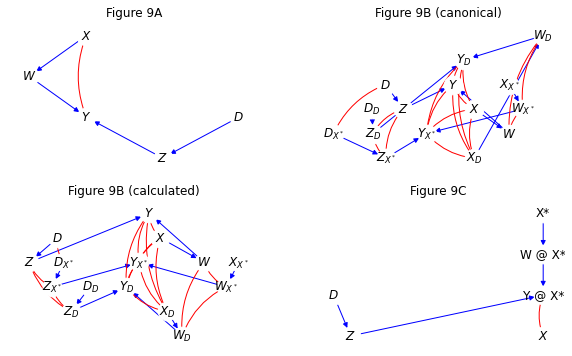

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6.0))

figure_9a.graph.draw(ax=axes[0][0], title="Figure 9A")
str_nodes_to_expr_nodes(figure_9b.graph).draw(ax=axes[0][1], title="Figure 9B (canonical)")
figure_9b_calculated.draw(ax=axes[1][0], title="Figure 9B (calculated)")
figure_9c.graph.draw(ax=axes[1][1], title="Figure 9C")
plt.show()

In [4]:
figure_9b_calculated == str_nodes_to_expr_nodes(figure_9b.graph)

True

In [5]:
figure_9_query = P(Y @ X | ~X, Z @ D, D)
figure_9_query

P(Y @ X | D, ~X, Z @ D)